##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Keras RNN API

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/beta/guide/keras/rnn">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/r2/guide/keras/rnn.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/r2/guide/keras/rnn.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a target="_blank" href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/r2/guide/keras/rnn.ipynb">
    <img src="https://www.tensorflow.org/images/download_logo_32px.png" />
    Download notebook</a>
  </td>
</table>


Recurrent neural network (RNN) is a class of neural network that is very powerful for solving problem with sequential data input. Unlike the feedforward network, an RNN maintains an internal state which is updated at each time-step. allowing it to explore the temporal feature of the input.

In Keras, RNN API is designed with the focus of:

- *Easy to use*<br>
  Builtin `tf.keras.layer.RNN`/`tf.keras.layers.LSTM`/`tf.keras.layers.GRU` layers allow you to quickly build the model by stacking them with Keras `sequential` model, or in `functional` model style.
- *Easy to extend*<br>
  You could also define your own `tf.keras.layers.AbstractRNNCell` with custom behavior, and use it with RNN layer. This allows you to quickly prototype different research ideas with minimal amount of code.


  

## Setup

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import collections
import matplotlib.pyplot as plt
import numpy as np

!pip install -q tensorflow-gpu==2.0.0-beta1
import tensorflow as tf

from tensorflow.keras import layers

## Build a simple model


There are three builtin RNN layers:

1. `tf.keras.layers.SimpleRNN`, fully-connected RNN where the output from previous timestep is to be fed to next timestep.

1. `tf.keras.layers.GRU`, gated recurrent unit that is first proposed in [https://arxiv.org/abs/1406.1078]

1. `tf.keras.layers.LSTM`, Long Short-Term Memory layer that is first proposed in [https://www.bioinf.jku.at/publications/older/2604.pdf].


In [3]:
model = tf.keras.Sequential()
# Add an embedding layer which the expectation of input vocab to be 1000, and
# output embedding domain to be 64.
model.add(layers.Embedding(input_dim=1000, output_dim=64))

# Add an LSTM layer with 128 internal units.
model.add(layers.LSTM(128))

# Add an Dense layer with 10 units and softmax activation.
model.add(layers.Dense(10, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          64000     
_________________________________________________________________
lstm (LSTM)                  (None, 128)               98816     
_________________________________________________________________
dense (Dense)                (None, 10)                1290      
Total params: 164,106
Trainable params: 164,106
Non-trainable params: 0
_________________________________________________________________


## Output and states

By default, the output of the RNN layer is the computation result for the last timestep. The shape of the output is usually `[batch, units]` where the units is the configured during the layer initialization. 

Instead of just returning the final timestep output, the layer could be configured to return the output for the whole sequence. To enable that, set the `return_sequences` parameter to `True` when creating the layer.

In [4]:
model = tf.keras.Sequential()
model.add(layers.Embedding(input_dim=1000, output_dim=64))

# The output shape for GRU will be a 3D tensor [batch, sequence, 64]
model.add(layers.GRU(64, return_sequences=True))
model.add(layers.SimpleRNN(128))
model.add(layers.Dense(10, activation='softmax'))

model.summary() 

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 64)          64000     
_________________________________________________________________
gru (GRU)                    (None, None, 64)          24960     
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 128)               24704     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 114,954
Trainable params: 114,954
Non-trainable params: 0
_________________________________________________________________


In addition, a layer could return the final internal state. The returned states can be used continue the RNN execution later, or to [initialize another RNN](https://arxiv.org/abs/1409.3215). This setting is commonly used in the encoder-decoder model, where the encoder final state is feed to decoder as initial state.

To enable that, set the `return_state` parameter to `True` when creating the layer.

To config the initial state of the layer, just call the layer with additional keyword argument "initial_state". Note that the shape of the state need to match with the unit size of the layer, which is way both LSTM layers are configured to have same size 64 in the example below.

In [5]:
encoder_vocab = 1000
decoder_vocab = 2000

encoder_input = layers.Input(shape=(None, ))
encoder_embedded = layers.Embedding(input_dim=encoder_vocab, output_dim=64)(encoder_input)

output, state_h, state_c = layers.LSTM(
    64, return_state=True, name='encoder')(encoder_embedded)
encoder_state = [state_h, state_c]

decoder_input = layers.Input(shape=(None, ))
decoder_embedded = layers.Embedding(input_dim=decoder_vocab, output_dim=64)(decoder_input)

decoder_output = layers.LSTM(
    64, name='decoder')(decoder_embedded, initial_state=encoder_state)
output = layers.Dense(10, activation='softmax')(decoder_output)

model = tf.keras.Model([encoder_input, decoder_input], output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, None, 64)     64000       input_1[0][0]                    
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, None, 64)     128000      input_2[0][0]                    
______________________________________________________________________________________________

To reuse the RNN state between batchs, you could make the RNN layer to be stateful by set `stateful=True` when construct the layer. It will make RNN layer to keep reusing the final states from the last batch and use it as the initial state for next batch. This allows RNN to explore the feature between batchs, rather than treat individual batch separately.

In [6]:
paragraph1 = np.random.random((20, 10, 50)).astype(np.float32)
paragraph2 = np.random.random((20, 10, 50)).astype(np.float32)
paragraph3 = np.random.random((20, 10, 50)).astype(np.float32)

# This is same as feeding paragraph1, 2 and 3 that is concat together on axis 1,
# which has shape [20, 30, 50]. It allows user to use samller amount of memory. 
lstm_layer = layers.LSTM(64, stateful=True)
output = lstm_layer(paragraph1)
output = lstm_layer(paragraph2)
output = lstm_layer(paragraph3)

# reset_state() will reset the cached state to original initial_state, in the
# case that no initial_state is provided, zeros will be used as default.
lstm_layer.reset_states()


##Bidirectional RNN

For sequential inputs, it is often that the model can perform better if it not only process the input from start to end, but also backwards. For example, to predict the next word in the sentence, it is often to have the context around the word, not only just the words in front of it.

Keras provides an easy API for you to build bidirectional RNN, by `tf.keras.layers.Bidirectional` wrapper.

In [7]:
model = tf.keras.Sequential()

model.add(layers.Bidirectional(layers.LSTM(64, return_sequences=True), 
                               input_shape=(5, 10)))
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(10, activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 5, 128)            38400     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                650       
Total params: 80,266
Trainable params: 80,266
Non-trainable params: 0
_________________________________________________________________


Under the hood, `Bidirectional` will copy the RNN layer passed in, flip the `go_backwards` field of the newly copied layer, so that it will process the inputs in a reversed order.

The output of the `Bidirectional` RNN will be, by default, add the forward layer output with backward layer output. If you want to have different behavior, eg concat the output, or not merge them at all, change the `merge_mode` parameter during `Bidirectional` wrapper initialization. For more details about `Bidirectional`, please check the API doc in https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers/Bidirectional.

## Performance upgrade and CuDNN kernel in 2.0

In Tensorflow 2.0, the built-in RNN layer has been updated to leverage CuDNN kernel by default when GPU is available. With this change, the existing `keras.layers.CuDNNLSTM/CuDNNGRU` layer can be deprecated, and you can build the model without worrying about the hardware constraint.

Since the CuDNN kernel is built with certain assumptions, this means the layer will not be able to use the CuDNN kernel if you configure the build-in layer with some custom behavior. Eg:

- Change the `activation` function from `tanh` to something else.
- Change the `recurrent_activation` function from `sigmoid` to something else.
- Use `recurrent_dropout` > 0
- Set `unroll` to True, which force LSTM/GRU to decompose the tf.while loop into a series operations.
- Does not use bias.
- When using masked input, the input data is not strictly right padded.

For the detailed list of contrains, please see the docstring for [LSTM](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers/LSTM) and [GRU](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers/GRU) layer.

### Use CuDNN kernel when available

Let's build a simple RNN model to train and predict with MNIST dataset to demonstrate the performance difference. 


In [8]:
batch_size = 64
# MNIST input is a (batch, 28, 28, 1) image.
# timestep is the first 28 here, and the input_size is the second 28.
timestep = 28
input_size = 28

units = 64
output_size = 10  # label is from 0~9

# Build the RNN model
def build_model(allow_cudnn_kernel=True):
  # CuDNN kernel is only available at layer level, and not on cell level.
  # This means LSTM(units) will land on CuDNN kernel, while RNN(LSTMCell(units))
  # will run on non-CuDNN kernel.
  if allow_cudnn_kernel:
    lstm_layer = tf.keras.layers.LSTM(units, input_shape=(timestep, input_size))
  else:
    lstm_layer = tf.keras.layers.RNN(
        tf.keras.layers.LSTMCell(units),
        input_shape=(timestep, input_size))
  model = tf.keras.models.Sequential([
      lstm_layer,
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Dense(output_size, activation='softmax')]
  )
  return model


### Load MNIST dataset

In [9]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
sample, sample_label = x_train[0], y_train[0]

11493376/11490434 [==============================] - 0s 0us/step


### Create model instance and compile it
We choose `sparse_categorical_crossentropy` as the loss function for the model. The output of the model is a logit after `softmax` activation, which has the shape of `[batch, 10]`. The target for the model is a integer vector, each of the integer is in the range of 0 to 9. `sparse_categorical_crossentropy` will properly map the logits output to the integer (index).

In [10]:
model = build_model(allow_cudnn_kernel=True)

model.compile(loss='sparse_categorical_crossentropy', 
              optimizer='sgd',
              metrics=['accuracy'])


In [11]:
model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=batch_size, epochs=5)

W0712 00:52:48.153316 140616482031360 deprecation.py:323] From /tmpfs/src/tf_docs_env/lib/python3.5/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 8s 126us/sample - loss: 0.9204 - accuracy: 0.7047 - val_loss: 0.5371 - val_accuracy: 0.8219
Epoch 2/5
60000/60000 [==============================] - 6s 99us/sample - loss: 0.3720 - accuracy: 0.8893 - val_loss: 0.2942 - val_accuracy: 0.9100
Epoch 3/5
60000/60000 [==============================] - 6s 102us/sample - loss: 0.2457 - accuracy: 0.9267 - val_loss: 0.2447 - val_accuracy: 0.9232
Epoch 4/5
60000/60000 [==============================] - 6s 103us/sample - loss: 0.1963 - accuracy: 0.9410 - val_loss: 0.2004 - val_accuracy: 0.9342
Epoch 5/5
60000/60000 [==============================] - 7s 116us/sample - loss: 0.1697 - accuracy: 0.9489 - val_loss: 0.3147 - val_accuracy: 0.8942


### Build a new model without CuDNN kernel

In [12]:
slow_model = build_model(allow_cudnn_kernel=False)
slow_model.set_weights(model.get_weights())
slow_model.compile(loss='sparse_categorical_crossentropy', 
                   optimizer='sgd', 
                   metrics=['accuracy'])
slow_model.fit(x_train, y_train, 
               validation_data=(x_test, y_test), 
               batch_size=batch_size)

Train on 60000 samples, validate on 10000 samples
60000/60000 [==============================] - 34s 574us/sample - loss: 0.1516 - accuracy: 0.9545 - val_loss: 0.1554 - val_accuracy: 0.9493


As you can see at this point, the model built with CuDNN kernel is much fast to train, comparing to the model that use normal kernel. With the new implementation of LSTM/GRU layer, user could train their model without the hardware constrains in mind. The same model code can be deployed to any enviornment.

The same model can also be use to run single step inference on CPU only environment. The tf.device annotation below is just forcing the device placement. The model will run on CPU by default if GPU is not avaiable.

Predicted result is: [5], target result is: 5


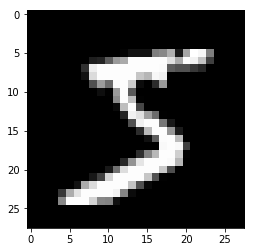

In [13]:

with tf.device("CPU:0"):
  cpu_model = build_model(allow_cudnn_kernel=True)
  cpu_model.set_weights(model.get_weights())
  result = tf.argmax(cpu_model.predict_on_batch(tf.expand_dims(sample, 0)), axis=1)
  print("Predicted result is: %s, target result is: %s" % (result.numpy(), sample_label))
  plt.imshow(sample, cmap=plt.get_cmap("gray"))

## Layer and cell

In addition to built-in RNN layers, the RNN API also provide cell level API for user to use. In contrast to RNN layer, which processes the whole input sequence, the RNN cell focuses on the input for a single timestep.

There are three built-in RNN cells, each of them corresponds to the matching RNN layer.

- `tf.keras.layers.SimpleRNNCell` matches to SimpleRNN layer.

- `tf.keras.layers.GRUCell` matches to GRU layer.

- `tf.keras.layers.LSTMCell` matches to LSTM layer.

Mathametically `RNN(SimpleRNNCell(10))` should produce the same result as `SimpleRNN(10)`. In fact, the implementation of layer in TF v1.x is just creating the corresponding RNN cell and wrap it with RNN layer.  

## RNN with nested structure as input and output

Nested structure allow user to encapsulate more information within one single timestep. For example, a video frame could have audio input at the same time. The data shape for this case can be:

`[batch, timestep, {"video": [height, width, channel], "audio": [frequency]}]`

In another example, handwriting data could have both x and y for the current frequency of the finger, as well as how hard user is pressing. So the data representation will be:

`[batch, timestep, {"location": [x, y], "press": [force]}]`

In any of these cases, it will be nice to have access the overall data for the 
single timestep, so that the relationship between different data can be explored.

The following code gives an example for how to build a custom RNN cell that accept high dimentional input and process it.


### Define a custom cell that support nested input/output

In [14]:
NestedInput = collections.namedtuple('NestedInput', ['feature1', 'feature2'])
NestedState = collections.namedtuple('NestedState', ['state1', 'state2'])

class NestedCell(tf.keras.layers.Layer):

  def __init__(self, unit_1, unit_2, unit_3, **kwargs):
    self.unit_1 = unit_1
    self.unit_2 = unit_2
    self.unit_3 = unit_3
    self.state_size = NestedState(state1=unit_1, 
                                  state2=tf.TensorShape([unit_2, unit_3]))
    self.output_size = (unit_1, tf.TensorShape([unit_2, unit_3]))
    super(NestedCell, self).__init__(**kwargs)

  def build(self, inputs_shape):
    # expect input_shape to contain 2 items, [(batch, i1), (batch, i2, i3)]
    input_1 = inputs_shape.feature1[1]
    input_2, input_3 = inputs_shape.feature2[1:]

    self.kernel_1 = self.add_weight(
        shape=(input_1, self.unit_1), initializer='uniform', name='kernel_1')
    self.kernel_2_3 = self.add_weight(
        shape=(input_2, input_3, self.unit_2, self.unit_3),
        initializer='uniform',
        name='kernel_2_3')

  def call(self, inputs, states):
    # inputs should be in [(batch, input_1), (batch, input_2, input_3)]
    # state should be in shape [(batch, unit_1), (batch, unit_2, unit_3)]
    input_1, input_2 = tf.nest.flatten(inputs)
    s1, s2 = states

    output_1 = tf.matmul(input_1, self.kernel_1)
    output_2_3 = tf.einsum('bij,ijkl->bkl', input_2, self.kernel_2_3)
    state_1 = s1 + output_1
    state_2_3 = s2 + output_2_3

    output = [output_1, output_2_3]
    new_states = NestedState(state1=state_1, state2=state_2_3)

    return output, new_states

### Build a RNN model with nested input/output

With RNN cell defined, let's build a Keras model that uses the RNN layer and newly defined cell.

In [15]:
unit_1 = 10
unit_2 = 20
unit_3 = 30

input_1 = 32
input_2 = 64
input_3 = 32
batch_size = 64
num_batch = 100
timestep = 50

cell = NestedCell(unit_1, unit_2, unit_3)
rnn = tf.keras.layers.RNN(cell)

inp_1 = tf.keras.Input((None, input_1))
inp_2 = tf.keras.Input((None, input_2, input_3))

outputs = rnn(NestedInput(feature1=inp_1, feature2=inp_2))

model = tf.keras.models.Model([inp_1, inp_2], outputs)

model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

### Train the model with random generated data
Since there isn't a good candidate dataset for this model, numpy random is used here to show case that the model can be trained properly. 

In [16]:
input_1_data = np.random.random((batch_size * num_batch, timestep, input_1))
input_2_data = np.random.random((batch_size * num_batch, timestep, input_2, input_3))
target_1_data = np.random.random((batch_size * num_batch, unit_1))
target_2_data = np.random.random((batch_size * num_batch, unit_2, unit_3))
input_data = [input_1_data, input_2_data]
target_data = [target_1_data, target_2_data]

model.fit(input_data, target_data, batch_size=batch_size)

Train on 6400 samples
6400/6400 [==============================] - 8s 1ms/sample - loss: 0.3702 - rnn_1_loss: 0.1109 - rnn_1_1_loss: 0.2593 - rnn_1_accuracy: 0.0947 - rnn_1_1_accuracy: 0.0331


With the RNN layer API, You are only expected to define the math logic for individual step within the sequence, and Keras RNN layer will handle the sequence iteration for you. For more details, please visit the [API doc](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers/RNN).